# Obtaining the Data/Column Addition

- nfl.csv is adapted from a larger Kaggle Dataset (https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016?select=NFL+Play+by+Play+2009-2018+%28v5%29.csv)
- I created new columns to help identify potential patterns to predict whether a pass was a completion or not

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("nfl.csv")
df = df.drop(["Unnamed: 0"], axis=1)
encoder = LabelEncoder()

df = pd.get_dummies(df, columns=['pass_location', "pass_length"], drop_first=True)

df["pass_difficulty"] = df["air_yards"] / (df["pass_length_short"] + 1)
df["time_pressure"] = df["quarter_seconds_remaining"] / (df["down"] + 1)
df["firstdowndistance"] = df["ydstogo"] - (df["air_yards"] + df["yards_after_catch"])


   yardline_100  quarter_seconds_remaining  half_seconds_remaining  \
0          58.0                      893.0                  1793.0   
1          56.0                      815.0                  1715.0   
2          98.0                      760.0                  1660.0   
3          43.0                      684.0                  1584.0   
4          40.0                      648.0                  1548.0   

   game_seconds_remaining  qtr  down  ydstogo pass_length pass_location  \
0                  3593.0    1   1.0       10       short          left   
1                  3515.0    1   3.0        8        deep         right   
2                  3460.0    1   2.0       10       short          left   
3                  3384.0    1   1.0       10       short         right   
4                  3348.0    1   2.0        7       short          left   

   air_yards  yards_after_catch  qb_dropback  qb_scramble passer_player_id  \
0       -3.0                8.0          1.0      

# Preprocessing

The data preprocessing steps include:

1. Handling missing values.
2. Encoding categorical variables
3. Splitting the data into training and testing sets.
4. Normalizing the input features.
5. Handling class imbalance using SMOTE, since there tended to be more completions than incompletions


- Also used a heatmap to view the correlation data

complete_pass                1.000000
yards_after_catch            0.421503
pass_length_short            0.331199
pass_location_middle         0.070616
yardline_100                 0.060843
pass_location_right          0.045504
time_pressure                0.043842
ydstogo                      0.039916
game_seconds_remaining       0.029620
half_seconds_remaining       0.022495
quarter_seconds_remaining    0.019934
no_huddle                    0.011631
shotgun                      0.001041
qb_scramble                  0.000814
passer_player_id            -0.025116
qtr                         -0.025309
goal_to_go                  -0.043891
down                        -0.057003
firstdowndistance           -0.144969
receiver_player_id          -0.165126
air_yards                   -0.176065
pass_difficulty             -0.183626
qb_dropback                       NaN
Name: complete_pass, dtype: float64
{np.float32(0.0): np.int64(15486), np.float32(1.0): np.int64(21850)}


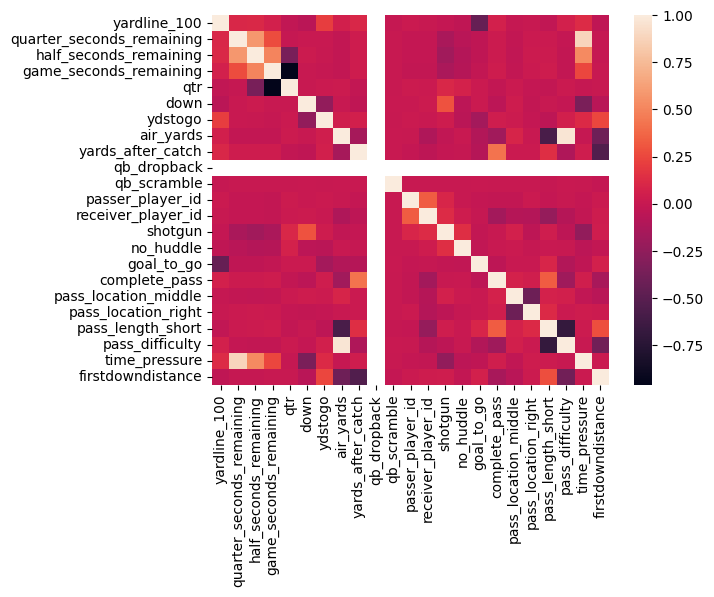

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE



df["passer_player_id"] = encoder.fit_transform(df["passer_player_id"])
df["receiver_player_id"] = encoder.fit_transform(df["receiver_player_id"])
df = df.fillna(0)


corr_with_complete = df.corr()["complete_pass"].sort_values(ascending=False)
print(corr_with_complete)


sns.heatmap(df.corr())

scaler = StandardScaler()

X = df.drop(columns=["complete_pass"], axis=1)
y = df["complete_pass"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


values, counts = np.unique(y_test, return_counts=True)
print(dict(zip(values, counts)))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# Model

- Input layer with 22 features.
- Three hidden layers with 256, 128, and 64 neurons respectively, each followed by batch normalization and ReLU activation.
- Output layer with a sigmoid activation function.


## Training

The model is compiled with the Adam optimizer and binary cross-entropy loss. The learning rate is scheduled to reduce on plateau, and the model is trained for 10 epochs with a batch size of 32.

## Evaluation

The model is evaluated on the test set, and the test loss and accuracy are printed.

In [9]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Input(shape=(22,)),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation = "sigmoid")
])


lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size = 32, callbacks=[lr_scheduler])

results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Epoch 1/10
5450/5450 ━━━━━━━━━━━━━━━━━━━━ 4s 592us/step - accuracy: 0.9096 - loss: 0.2015 - val_accuracy: 0.9811 - val_loss: 0.0474 - learning_rate: 5.0000e-04
Epoch 2/10
5450/5450 ━━━━━━━━━━━━━━━━━━━━ 3s 578us/step - accuracy: 0.9798 - loss: 0.0524 - val_accuracy: 0.9834 - val_loss: 0.0414 - learning_rate: 5.0000e-04
Epoch 3/10
5450/5450 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step - accuracy: 0.9832 - loss: 0.0442 - val_accuracy: 0.9829 - val_loss: 0.0423 - learning_rate: 5.0000e-04
Epoch 4/10
5450/5450 ━━━━━━━━━━━━━━━━━━━━ 3s 556us/step - accuracy: 0.9843 - loss: 0.0404 - val_accuracy: 0.9830 - val_loss: 0.0384 - learning_rate: 5.0000e-04
Epoch 5/10
5450/5450 ━━━━━━━━━━━━━━━━━━━━ 3s 552us/step - accuracy: 0.9844 - loss: 0.0397 - val_accuracy: 0.9836 - val_loss: 0.0407 - learning_rate: 5.0000e-04
Epoch 6/10
5450/5450 ━━━━━━━━━━━━━━━━━━━━ 3s 551us/step - accuracy: 0.9850 - loss: 0.0378 - val_accuracy: 0.9837 - val_loss: 0.0382 - learning_rate: 5.0000e-04
Epoch 7/10
5450/5450 ━━━━━━━━━━━━━━━━━━━